# The Future is Now: Patterns in Global Temperature Trends Across the World

While we all know that global temperatures are on the rise, mass media tends to lack nuance on the topic with its goals of compressing information into brief soundbytes.

For example, it's often not mentioned that the global temperature rise is based on *average* global temperatures, rather than day-to-day, which often leads people to conflate climate and weather. It is also worth highlighting that averages can be skewed by outliers - i.e., unusually hot or cold temperatures on just a few days out of a month can make the average temperature for that month higher or lower by several degrees.

Another feature of climate change not often highlighted is that different parts of the world are warming at different rates,  i.e. some parts of the world are more at risk for the various consequences of climate change than others, particularly in the short term (decades). 

The goal of this analysis is to find which parts of the world have warmed the most. What geographic trends will we find? What regions of the world are most at risk? With data mining techniques, we can better understand which parts of the world will be most at risk, and help provide a more nuanced understanding of climate change.

The following analysis is based on this dataset: [Global Temperature Records (1743-2013)](https://www.kaggle.com/datasets/maso0dahmed/global-temperature-records-1850-2022).

## Virtual Environment Setup

Recommended if running locally; not needed if running on Colab or similar.

Add a code cell that runs the following command:
`!py -3 -m venv .venv`

Then in the top right in VS Code click the Python version and set it to the `.venv` interpreter found in this folder.

## Install Dependencies

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels

Note: you may need to restart the kernel to use updated packages.


## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import pycountry_convert as pc
from kgcPy import lookupCZ

In [3]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)

## Data preprocessing & Exploratory Data Analysis (EDA)

For our first step, I need to examine the data, and determine if there are any data missing; if there are, I should investigate patterns in the missing data.

dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64


<Axes: >

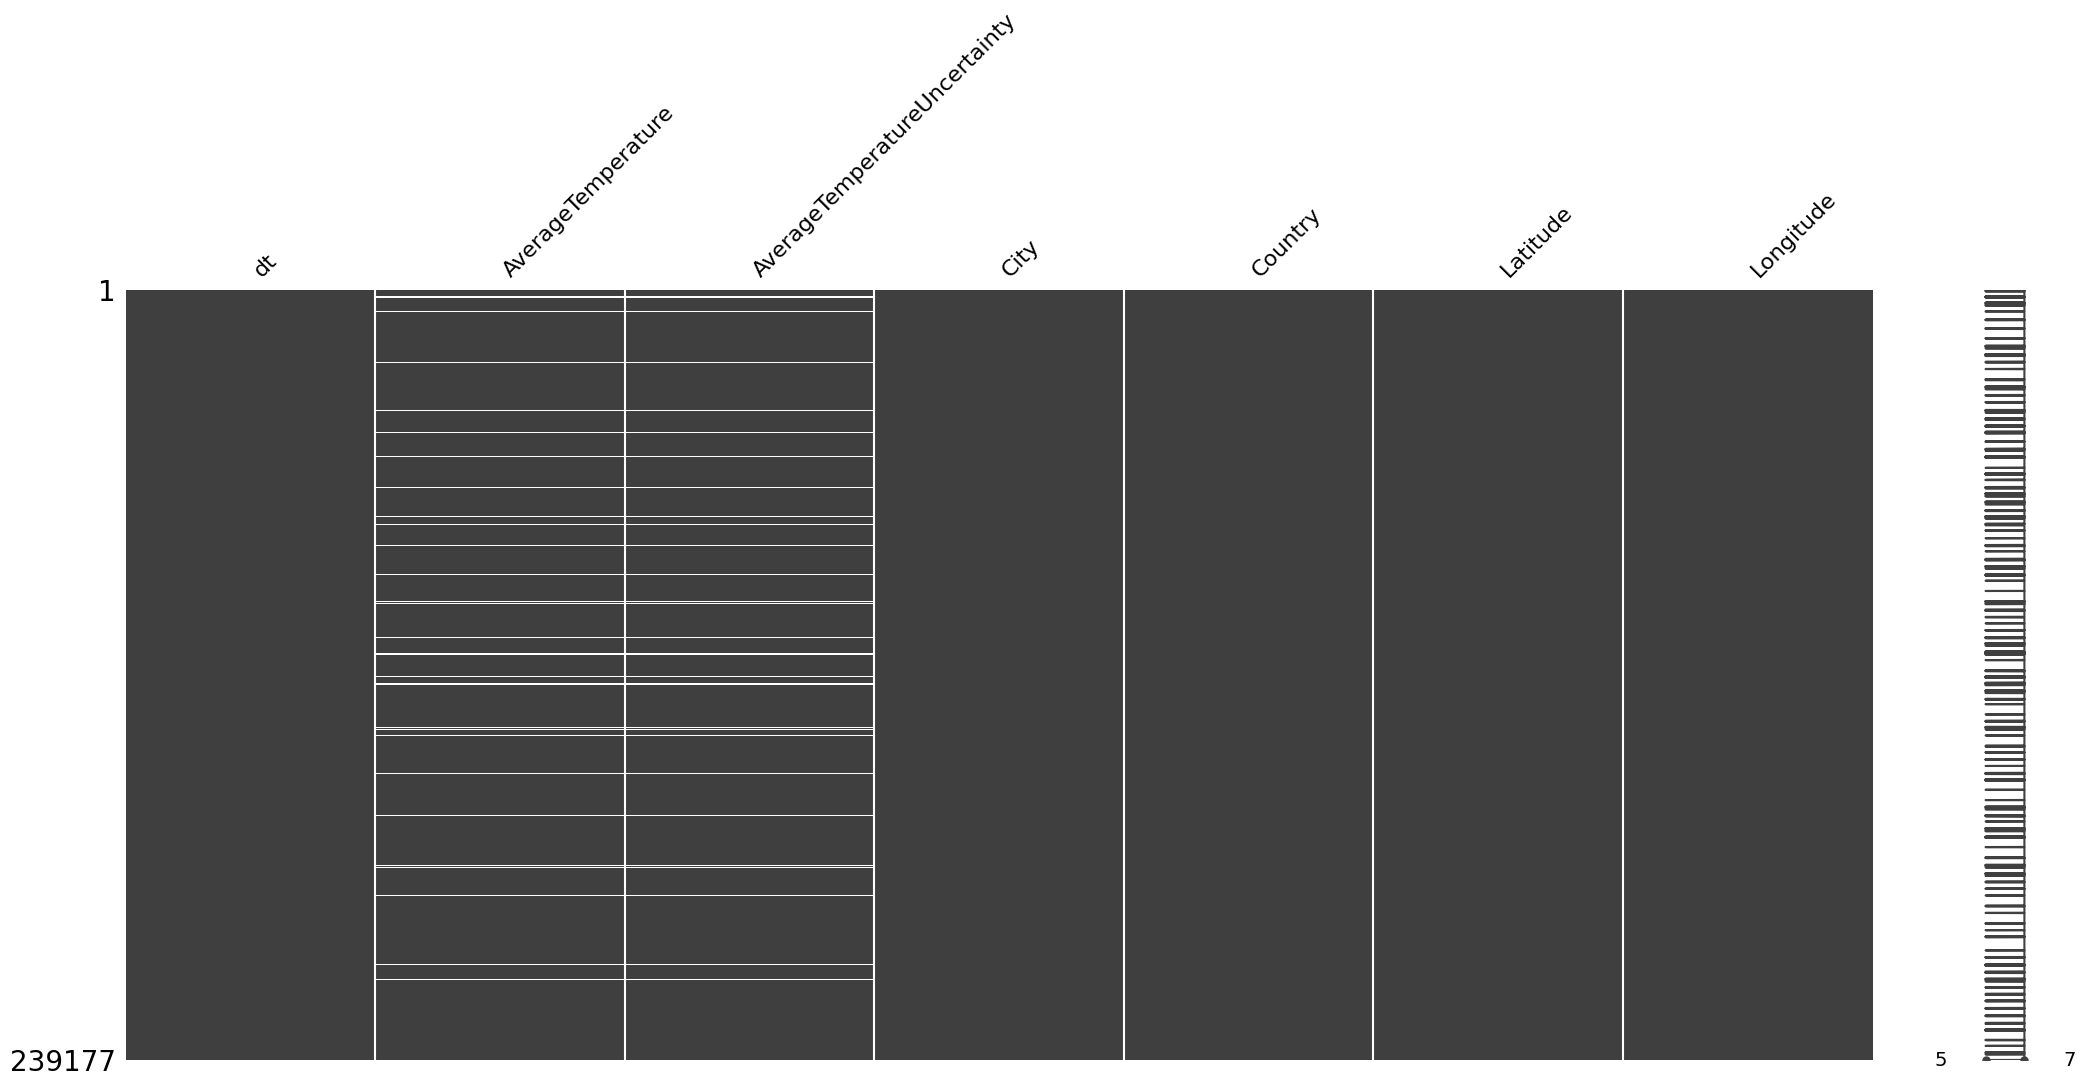

In [4]:
with open('GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv', 'r') as file:
    df = pd.read_csv(file)

# Find missing values (if any) and where they are
missing = df.isnull().sum()
print(missing)

msno.matrix(df)

Quick look at how the data is organized

In [5]:
unique_cities_count = df['City'].nunique()
print(f"Number of unique cities: {unique_cities_count}")

unique_cities_count = df['Country'].nunique()
print(f"Number of unique countries: {unique_cities_count}")

print(df)

df.describe()

Number of unique cities: 100
Number of unique countries: 49
                dt  AverageTemperature  AverageTemperatureUncertainty  \
0       1849-01-01              26.704                          1.435   
1       1849-02-01              27.434                          1.362   
2       1849-03-01              28.101                          1.612   
3       1849-04-01              26.140                          1.387   
4       1849-05-01              25.427                          1.200   
...            ...                 ...                            ...   
239172  2013-05-01              18.979                          0.807   
239173  2013-06-01              23.522                          0.647   
239174  2013-07-01              25.251                          1.042   
239175  2013-08-01              24.528                          0.840   
239176  2013-09-01                 NaN                            NaN   

           City        Country Latitude Longitude  
0       Abi

,AverageTemperature,AverageTemperatureUncertainty
count,228175.000000,228175.000000
mean,18.125969,0.969343
std,10.024800,0.979644
min,-26.772000,0.040000
25%,12.710000,0.340000
50%,20.428000,0.592000
75%,25.918000,1.320000
max,38.283000,14.037000


### Missing Data & Reliability

From the output above we can see that there are a lot of missing data points, but all of them are in the AverageTemperature column and its dependent column, AverageTemperatureUncertainty. Next I will try to find patterns in the missing values (certain countries or years) to decide on how to approach them.

#### Adjust Years to only include data from 1880 and beyond

For the most robust interpretations, we will only include data from the year 1880 and beyond.

**Why start at the Year 1880?**

- This is the starting year used most consistently by the National Oceanic and Atmospheric Administration (NOAA) and National Aueronautics and Space Administration (NASA)
- Available temperature data started covering more of the planet around this time so analyses and interpretations are more reliable
- Measurement uncertainty decreases to an acceptable level around this time

In [6]:
# Convert 'dt' to datetime and extract the year
df['Year'] = pd.to_datetime(df['dt']).dt.year
df = df[df['Year'] >= 1880]

# Group by city/year to find where most of the values are missing
df_missing_city_year = df[df['AverageTemperature'].isnull()].groupby(['City', 'Year']).size().reset_index(name='MissingCount')
print('Missing Average Temperature entries by year and city:')
print(df_missing_city_year)

# Look at just city to see geographical trends
df_missing_city = df[df['AverageTemperature'].isnull()].groupby('City').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by city:')
print(df_missing_city)

# Look at just year to see temporal trends
df_missing_years_city = df[df['AverageTemperature'].isnull()].groupby('Year').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by year (across all cities):')
print(df_missing_years_city)

# Get rid of rows where AverageTemperatureUncertainty is > 5 degrees Celsius and see how that changes things
df = df[df['AverageTemperatureUncertainty'] <= 5]

print('---------------------------------------------------')
print('Results after removing rows where AverageTemperatureUncertainty > 5')

# Group by city/year to find where most of the values are missing
df_missing_city_year = df[df['AverageTemperature'].isnull()].groupby(['City', 'Year']).size().reset_index(name='MissingCount')
print('Missing Average Temperature entries by year and city:')
print(df_missing_city_year)

# Look at just city to see geographical trends
df_missing_city = df[df['AverageTemperature'].isnull()].groupby('City').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by city:')
print(df_missing_city)

# Look at just year to see temporal trends
df_missing_years_city = df[df['AverageTemperature'].isnull()].groupby('Year').size().reset_index(name='MissingCount').sort_values(by='MissingCount', ascending=False)
print('\nMissing Average Temperature entries by year (across all cities):')
print(df_missing_years_city)

Missing Average Temperature entries by year and city:
            City  Year  MissingCount
0        Abidjan  1884             4
1        Abidjan  1885            10
2        Abidjan  2013             1
3    Addis Abeba  1880             1
4    Addis Abeba  1881             1
..           ...   ...           ...
133      Tianjin  2013             1
134        Tokyo  2013             1
135   Umm Durman  2013             1
136        Wuhan  2013             1
137         Xian  2013             1

[138 rows x 3 columns]

Missing Average Temperature entries by city:
             City  MissingCount
24  Dar Es Salaam            96
29      Fortaleza            85
52           Lima            70
44           Kano            15
36         Ibadan            15
..            ...           ...
31      Guangzhou             1
30          Gizeh             1
28     Faisalabad             1
26          Dhaka             1
92           Xian             1

[93 rows x 2 columns]

Missing Average Temperat

Visualization of Missing Data

**Update 3/28/2024: filtering to exclude where AverageTemperatureUncertainty >5 results in no missing data**

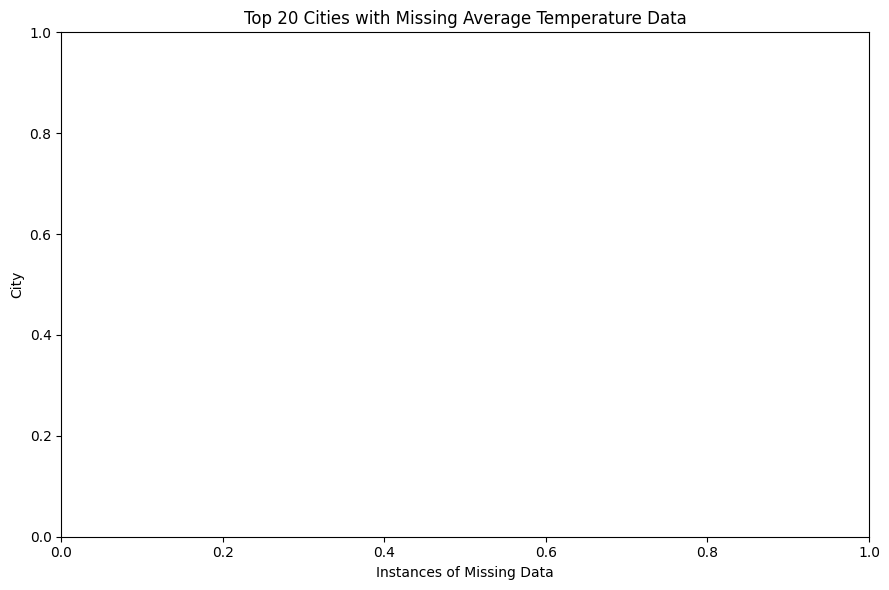

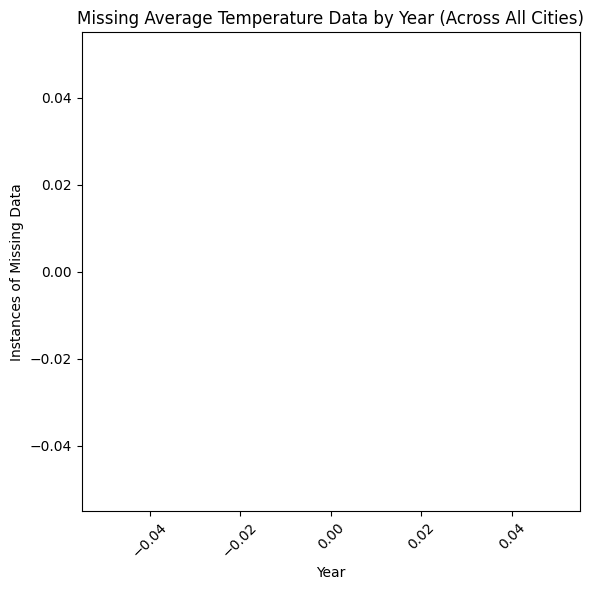

In [7]:
plt.figure(figsize=(9, 6))
plot = sns.barplot(x='MissingCount', y='City', data=df_missing_city.head(20), color='orange')
plt.title('Top 20 Cities with Missing Average Temperature Data')
plt.xlabel('Instances of Missing Data')
plt.ylabel('City')

# Adjusting text placement for readability
for bar in plot.patches:
    width = bar.get_width()
    plot.text(width + 3, bar.get_y() + bar.get_height() / 2, '{:1.0f}'.format(width), va='center')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sns.lineplot(x='Year', y='MissingCount', data=df_missing_years_city, marker='o', color='b')
plt.title('Missing Average Temperature Data by Year (Across All Cities)')
plt.xlabel('Year')
plt.ylabel('Instances of Missing Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Handling Years With Missing Data

Inevitably, some years will have a month or perhaps a whole year's Average Temperature data missing.

Including years with some months missing could easily misrepresent the average, particularly for countries far from the equator, where there can be a large seasonal variation in temperature. We want to minimize the influence of incomplete or missing data.

To keep the reliability and integrity of this data analysis, I will be using the following approach:

1. Exclude all years for a city where at least 1 month is missing a value for AverageTemperature, put that in a new dataframe.
2. Average the temperature for each year on the rest of the data, so we can compare temperature trends over time across countries.

In [8]:
# Step 1: 

# Find any cities that have missing temperature data for a year
missing_AverageTemperature = df.groupby(['City', 'Year'])['AverageTemperature'].apply(lambda x: x.isnull().any()).reset_index(name='HasMissing')

# Create a new df that only includes years without missing data
df_no_missing = missing_AverageTemperature[~missing_AverageTemperature['HasMissing']]

# Filter to only include rows with complete years - now we've only got years with 0 missing Average Temperature entries
df_no_missing = pd.merge(df, df_no_missing[['City', 'Year']], on=['City', 'Year'], how='inner')

# Step 2:

# Calculate the average temperature for each city by year
df_AverageTemperature_City_Year = df_no_missing.groupby(['City', 'Year'])['AverageTemperature'].mean().reset_index()

print(df_AverageTemperature_City_Year)

df_AverageTemperature_City_Year.describe()

          City  Year  AverageTemperature
0      Abidjan  1880           25.957083
1      Abidjan  1881           26.073333
2      Abidjan  1882           25.687167
3      Abidjan  1883           26.131333
4      Abidjan  1884           26.366625
...        ...   ...                 ...
13375     Xian  2009           12.528417
13376     Xian  2010           12.589750
13377     Xian  2011           12.075167
13378     Xian  2012           11.898167
13379     Xian  2013           14.460000

[13380 rows x 3 columns]


,Year,AverageTemperature
count,13380.000000,13380.000000
mean,1946.592302,18.923682
std,38.637778,7.265445
min,1880.000000,1.317000
25%,1913.000000,12.491375
50%,1947.000000,20.600125
75%,1980.000000,25.706750
max,2013.000000,30.730167


We want to exclude years with too few data points. As shown below, the most data points we have for any city is 49. We will only keep those with about 2/3 of that number (32) both for accuracy and to keep as many data points as reasonable for later analysis.

In [9]:
unique_cities_count = df_AverageTemperature_City_Year['City'].nunique()
print(f'Number of unique cities: {unique_cities_count}')

# Group by Year and count the number of data points (countries) for each year
num_data_points = df_AverageTemperature_City_Year.groupby('Year').size()

# Print minimum and maximum number of data points across all years
print(f'Minimum data points in a year: {num_data_points.min()}')
print(f'Maximum data points in a year: {num_data_points.max()}')

# Find years with fewer than 1/3 * max data points
threshold = (1/3) * num_data_points.max()
years_with_lt_one_third = num_data_points[num_data_points < threshold]

print(f'Number of years with fewer than {int(threshold)} data points: {len(years_with_lt_one_third)}')
print(years_with_lt_one_third)

Number of unique cities: 100
Minimum data points in a year: 97
Maximum data points in a year: 100
Number of years with fewer than 33 data points: 0
Series([], dtype: int64)


In [10]:
years_to_exclude = years_with_lt_one_third.index.tolist()
df_AverageTemperature_City_Year = df_AverageTemperature_City_Year[~df_AverageTemperature_City_Year['Year'].isin(years_to_exclude)]

The most data points we have for a year is 100/100, and the least is 7/100. We have filtered our dataframe to only include those with at least 44 unique cities.

### View of Average Temperature Over Time for 5 Random Countries

To verify that my approach is giving the correct results, I have decided to graph 5 random countries' average temperature over time.
Your results will be different every time you run the following cell.

In [11]:
print(df_AverageTemperature_City_Year)

          City  Year  AverageTemperature
0      Abidjan  1880           25.957083
1      Abidjan  1881           26.073333
2      Abidjan  1882           25.687167
3      Abidjan  1883           26.131333
4      Abidjan  1884           26.366625
...        ...   ...                 ...
13375     Xian  2009           12.528417
13376     Xian  2010           12.589750
13377     Xian  2011           12.075167
13378     Xian  2012           11.898167
13379     Xian  2013           14.460000

[13380 rows x 3 columns]


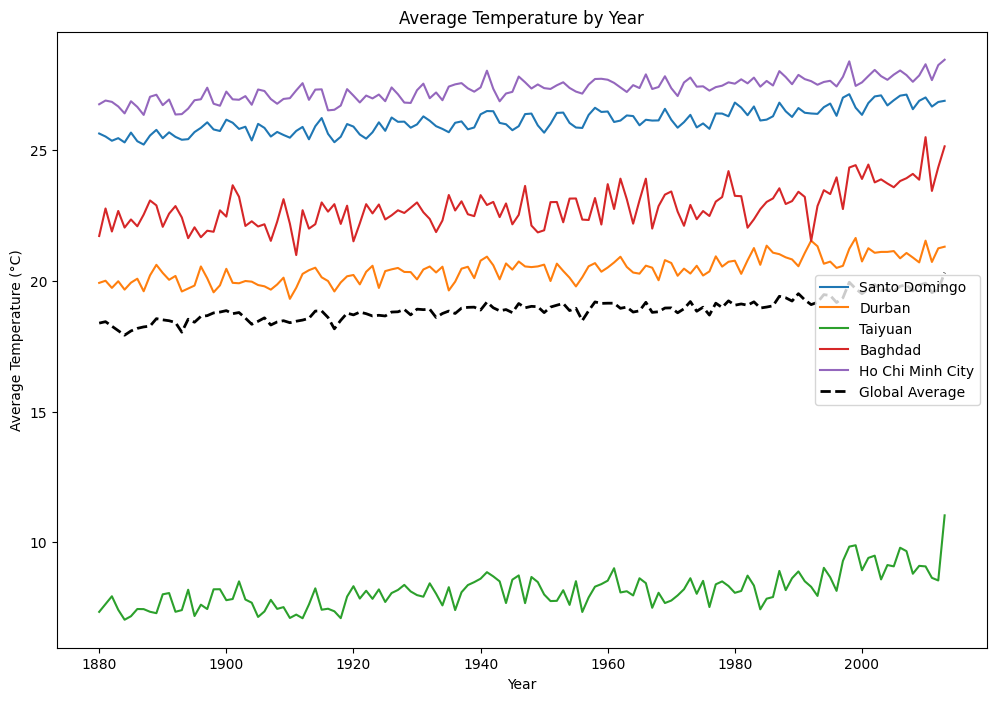

In [12]:
# Get list of unique countries so we can graph by country
unique_cities = df_AverageTemperature_City_Year['City'].unique()

# Pick 5 random countries
selected_cities = np.random.choice(unique_cities, 5, replace=False)

plt.figure(figsize=(12, 8))

# Graph AverageTemperature vs. Year for the 5 random countries
for city in selected_cities:
    city_data = df_AverageTemperature_City_Year[df_AverageTemperature_City_Year['City'] == city]
    plt.plot(city_data['Year'], city_data['AverageTemperature'], label=city)

# Include global for comparison
df_global_average = df_AverageTemperature_City_Year.groupby('Year')['AverageTemperature'].mean().reset_index(name='GlobalAverageTemperature')
plt.plot(df_global_average['Year'], df_global_average['GlobalAverageTemperature'], label='Global Average', color='black', linewidth=2, linestyle='--')

plt.title('Average Temperature by Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

### Correlation Between Latitude and Average Temperature

Latitude is a value measured in degrees with range [-90, 90] that represents physical distance from the equator (0). Cities north of the equator have their latitude suffixed by N (positive), and those south of the equator have it suffixed by S (negative).

For this analysis it makes the most sense to look at absolute latitude to determine if there is a correlation between it and average temperature, since the output should be a line (if there is a correlation). However I will also be examining raw latitude as well, to see if there are any trends within just the Northern or Southern Hemisphere. We expect this curve to be a slightly skewed inverted-U shape since there is less landmass in the southern hemisphere.

It is expected that countries near the equator should have warmer average temperatures than those far from the equator.

In [13]:
additional_details = df_no_missing.groupby(['City', 'Year']).agg({
    'Country': 'first',
    'Latitude': 'first', 
    'Longitude': 'first'
}).reset_index()

# Merging back with df_AverageTemperature_City_Year
df_no_missing_updated = pd.merge(
    df_AverageTemperature_City_Year,
    additional_details,
    on=['City', 'Year'],
    how='left'
)

print(df_no_missing_updated)

df_no_missing_updated.describe()

          City  Year  AverageTemperature        Country Latitude Longitude
0      Abidjan  1880           25.957083  Cote D'Ivoire    5.63N     3.23W
1      Abidjan  1881           26.073333  Cote D'Ivoire    5.63N     3.23W
2      Abidjan  1882           25.687167  Cote D'Ivoire    5.63N     3.23W
3      Abidjan  1883           26.131333  Cote D'Ivoire    5.63N     3.23W
4      Abidjan  1884           26.366625  Cote D'Ivoire    5.63N     3.23W
...        ...   ...                 ...            ...      ...       ...
13375     Xian  2009           12.528417          China   34.56N   108.97E
13376     Xian  2010           12.589750          China   34.56N   108.97E
13377     Xian  2011           12.075167          China   34.56N   108.97E
13378     Xian  2012           11.898167          China   34.56N   108.97E
13379     Xian  2013           14.460000          China   34.56N   108.97E

[13380 rows x 6 columns]


,Year,AverageTemperature
count,13380.000000,13380.000000
mean,1946.592302,18.923682
std,38.637778,7.265445
min,1880.000000,1.317000
25%,1913.000000,12.491375
50%,1947.000000,20.600125
75%,1980.000000,25.706750
max,2013.000000,30.730167


In [14]:
# Add additional latitude/longitude columns for data visualization/processing
df_no_missing_updated['NumericLatitude'] = df_no_missing_updated['Latitude'].apply(lambda x: float(x[:-1]) if 'N' in x else -float(x[:-1]))
df_no_missing_updated['NumericLongitude'] = df_no_missing_updated['Longitude'].apply(lambda x: float(x[:-1]) if 'E' in x else -float(x[:-1]))
df_no_missing_updated['AbsLatitude'] = df_no_missing_updated['NumericLatitude'].abs()
df_no_missing_updated['AbsLongitude'] = df_no_missing_updated['NumericLongitude'].abs()

df_no_missing_updated = df_no_missing_updated.dropna(subset=['AverageTemperature'])

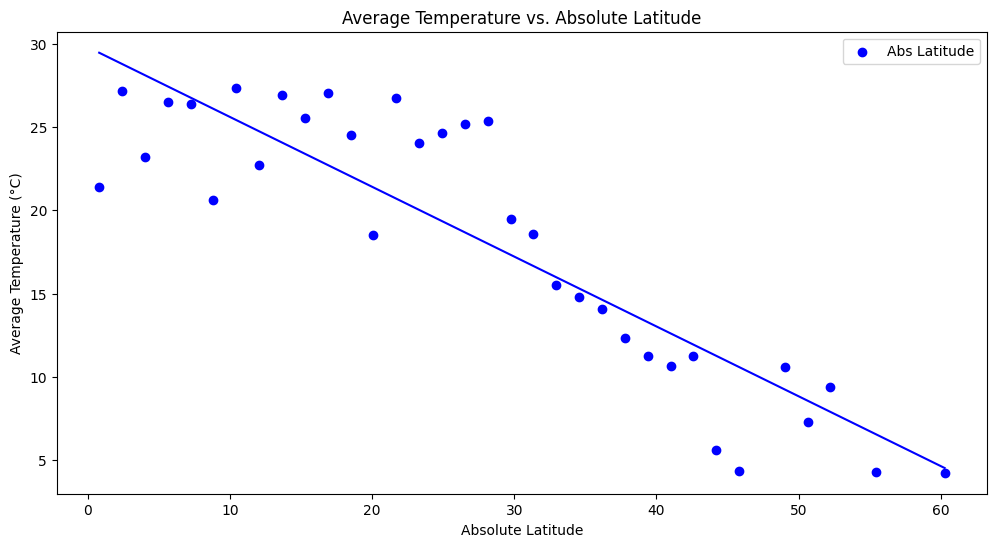

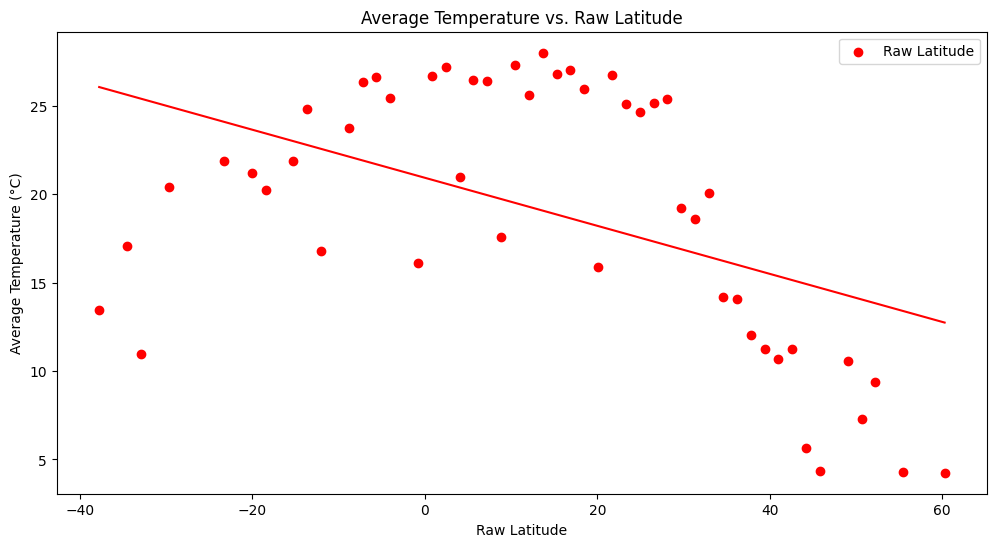

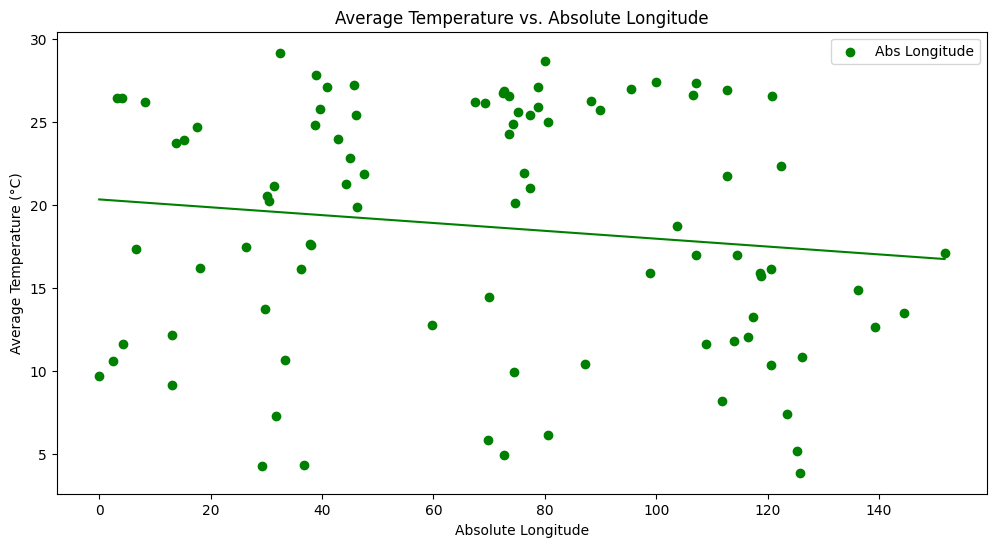

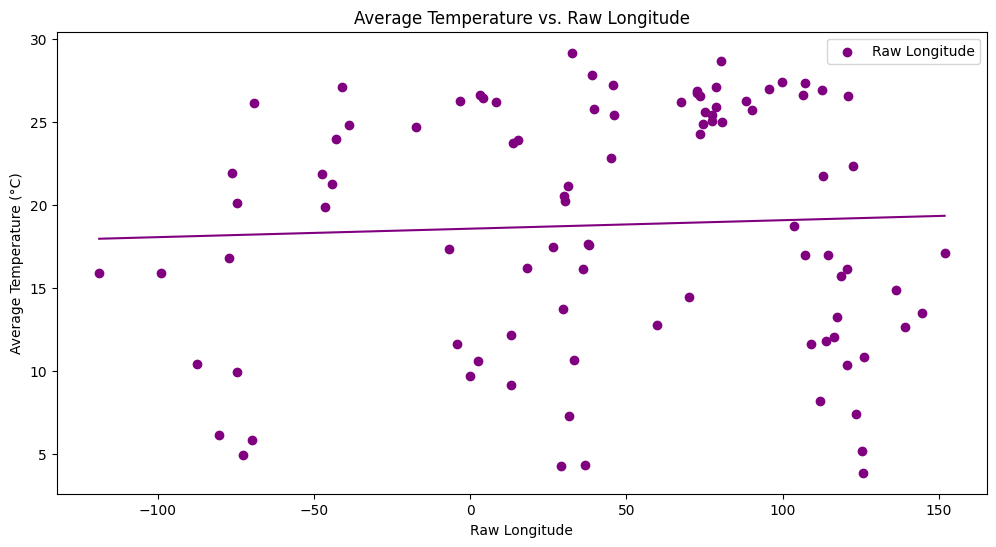

Correlation between Absolute Latitude and Average Temperature: -0.8837619691496567
Correlation between Raw Latitude and Average Temperature: -0.48229917109047876
Correlation between Absolute Longitude and Average Temperature: -0.7983026634421257
Correlation between Raw Longitude and Average Temperature: -0.3350451386695296


In [15]:
average_temp_by_latitude = df_no_missing_updated.groupby('AbsLatitude')['AverageTemperature'].mean().reset_index()
average_temp_by_raw_latitude = df_no_missing_updated.groupby('NumericLatitude')['AverageTemperature'].mean().reset_index()
average_temp_by_longitude = df_no_missing_updated.groupby('AbsLongitude')['AverageTemperature'].mean().reset_index()
average_temp_by_raw_longitude = df_no_missing_updated.groupby('NumericLongitude')['AverageTemperature'].mean().reset_index()

# Correlation Analysis
correlation_abs_lat = average_temp_by_latitude['AbsLatitude'].corr(average_temp_by_latitude['AverageTemperature'])
correlation_raw_lat = average_temp_by_raw_latitude['NumericLatitude'].corr(average_temp_by_raw_latitude['AverageTemperature'])
correlation_abs_long = average_temp_by_longitude['AbsLongitude'].corr(average_temp_by_latitude['AverageTemperature'])
correlation_raw_long = average_temp_by_raw_longitude['NumericLongitude'].corr(average_temp_by_raw_latitude['AverageTemperature'])

# Visualization for AbsLatitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_latitude['AbsLatitude'], average_temp_by_latitude['AverageTemperature'], color='blue', label='Abs Latitude')
m, b = np.polyfit(average_temp_by_latitude['AbsLatitude'], average_temp_by_latitude['AverageTemperature'], 1)
plt.plot(average_temp_by_latitude['AbsLatitude'], m*average_temp_by_latitude['AbsLatitude'] + b, color='blue')
plt.title('Average Temperature vs. Absolute Latitude')
plt.xlabel('Absolute Latitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for Raw Latitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_raw_latitude['NumericLatitude'], average_temp_by_raw_latitude['AverageTemperature'], color='red', label='Raw Latitude')
m, b = np.polyfit(average_temp_by_raw_latitude['NumericLatitude'], average_temp_by_raw_latitude['AverageTemperature'], 1)
plt.plot(average_temp_by_raw_latitude['NumericLatitude'], m*average_temp_by_raw_latitude['NumericLatitude'] + b, color='red')
plt.title('Average Temperature vs. Raw Latitude')
plt.xlabel('Raw Latitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for AbsLongitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_longitude['AbsLongitude'], average_temp_by_longitude['AverageTemperature'], color='green', label='Abs Longitude')
m, b = np.polyfit(average_temp_by_longitude['AbsLongitude'], average_temp_by_longitude['AverageTemperature'], 1)
plt.plot(average_temp_by_longitude['AbsLongitude'], m*average_temp_by_longitude['AbsLongitude'] + b, color='green')
plt.title('Average Temperature vs. Absolute Longitude')
plt.xlabel('Absolute Longitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Visualization for Raw Longitude
plt.figure(figsize=(12, 6))
plt.scatter(average_temp_by_raw_longitude['NumericLongitude'], average_temp_by_raw_longitude['AverageTemperature'], color='purple', label='Raw Longitude')
m, b = np.polyfit(average_temp_by_raw_longitude['NumericLongitude'], average_temp_by_raw_longitude['AverageTemperature'], 1)
plt.plot(average_temp_by_raw_longitude['NumericLongitude'], m*average_temp_by_raw_longitude['NumericLongitude'] + b, color='purple')
plt.title('Average Temperature vs. Raw Longitude')
plt.xlabel('Raw Longitude')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

print(f"Correlation between Absolute Latitude and Average Temperature: {correlation_abs_lat}")
print(f"Correlation between Raw Latitude and Average Temperature: {correlation_raw_lat}")
print(f"Correlation between Absolute Longitude and Average Temperature: {correlation_abs_long}")
print(f"Correlation between Raw Longitude and Average Temperature: {correlation_raw_long}")

For all but Absolute Latitude and Average Temperature, the lines are poor fits for the data. This makes sense since Latitude is a direct predictor of climate due to the angle at which solar radiation is received, while Longitude has no such effects.

The high correlation with Absolute Longitude and Average Temperature would seem viable had we not included the visualization, but clearly the data distribution is not linear. The large number of outliers greatly affects the slope of the regression line. This doesn't meant here is no relationship, however. There may be another relationship here that we can tease out.

### Results of Correlation Between Latitude and Average Temperature

The results are about as expected; a strong negative correlation between absolute latitude an negative temperature (r^2 ~= -0.88), and a nearly even correlation when raw latitude is used (expected r^2 ~= 0.50, actual ~= -0.48).

Perfect correlations are not to be expected, since many more factors affect local climates than distance from the equator, such as weather patterns and topography.

### Enhancing the Dataset

Adding a continent column to our dataset could potentially be useful to find macro-scale trends.

In [16]:
# Function to get continent name from country name
def country_to_continent(country_name):
    # Special cases (different country names than pycountry_convert uses)
    special_cases = {
        "Cote D'Ivoire": "Africa",
        "Congo (Democratic Republic Of The)": "Africa",
        "Burma": "Asia", 
    }
    
    if country_name in special_cases:
        return special_cases[country_name]
    
    try:
        # Get country code and continent code
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

df_no_missing_updated['Continent'] = df_no_missing_updated['Country'].apply(country_to_continent)

print(df_no_missing_updated)

# Verify that all countries were assigned a continent
none_continent_rows = df_no_missing_updated.loc[df_no_missing_updated['Continent'].isnull()]
print(none_continent_rows)


          City  Year  AverageTemperature        Country Latitude Longitude  \
0      Abidjan  1880           25.957083  Cote D'Ivoire    5.63N     3.23W   
1      Abidjan  1881           26.073333  Cote D'Ivoire    5.63N     3.23W   
2      Abidjan  1882           25.687167  Cote D'Ivoire    5.63N     3.23W   
3      Abidjan  1883           26.131333  Cote D'Ivoire    5.63N     3.23W   
4      Abidjan  1884           26.366625  Cote D'Ivoire    5.63N     3.23W   
...        ...   ...                 ...            ...      ...       ...   
13375     Xian  2009           12.528417          China   34.56N   108.97E   
13376     Xian  2010           12.589750          China   34.56N   108.97E   
13377     Xian  2011           12.075167          China   34.56N   108.97E   
13378     Xian  2012           11.898167          China   34.56N   108.97E   
13379     Xian  2013           14.460000          China   34.56N   108.97E   

       NumericLatitude  NumericLongitude  AbsLatitude  AbsLongi

c:\Users\jacob\Dropbox\2024 Spring\CS 457 DataMining\Temperature Patterns\.venv\lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
c:\Users\jacob\Dropbox\2024 Spring\CS 457 DataMining\Temperature Patterns\.venv\lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


### Enhancing the Dataset

The Köppen climate classification divides every region of the world into five main groups, each represented by a letter, and thirty subgroups with additional letters. We may be able to find tighter correlations between temperature trends if we also take into account the climate classification of each city in this dataset.

I will add a column with the Köppen climate classification for each city with data near the present day (1991-2020). Note it is expected these classifications will change over time as global average temperature increases. Data was obtained via the maps referenced in [this paper](https://www.nature.com/articles/sdata2018214).

In [17]:
unique_locations = df_no_missing_updated[['City', 'NumericLatitude', 'NumericLongitude']].drop_duplicates()

# Use to add kcc to df
def get_kcc_for_location(row):
    return lookupCZ(row['NumericLatitude'], row['NumericLongitude'])

unique_locations['kcc'] = unique_locations.apply(get_kcc_for_location, axis=1)
kcc_mapping = unique_locations.set_index('City')['kcc'].to_dict()

# Apply the mapping to the main DataFrame to fill in KCC for all rows quickly
df_no_missing_updated['kcc'] = df_no_missing_updated['City'].map(kcc_mapping)

In [18]:
print(df_no_missing_updated)

df_no_missing_updated.describe()

          City  Year  AverageTemperature        Country Latitude Longitude  \
0      Abidjan  1880           25.957083  Cote D'Ivoire    5.63N     3.23W   
1      Abidjan  1881           26.073333  Cote D'Ivoire    5.63N     3.23W   
2      Abidjan  1882           25.687167  Cote D'Ivoire    5.63N     3.23W   
3      Abidjan  1883           26.131333  Cote D'Ivoire    5.63N     3.23W   
4      Abidjan  1884           26.366625  Cote D'Ivoire    5.63N     3.23W   
...        ...   ...                 ...            ...      ...       ...   
13375     Xian  2009           12.528417          China   34.56N   108.97E   
13376     Xian  2010           12.589750          China   34.56N   108.97E   
13377     Xian  2011           12.075167          China   34.56N   108.97E   
13378     Xian  2012           11.898167          China   34.56N   108.97E   
13379     Xian  2013           14.460000          China   34.56N   108.97E   

       NumericLatitude  NumericLongitude  AbsLatitude  AbsLongi

,Year,AverageTemperature,NumericLatitude,NumericLongitude,AbsLatitude,AbsLongitude
count,13380.000000,13380.000000,13380.000000,13380.000000,13380.000000,13380.000000
mean,1946.592302,18.923682,20.101975,45.565155,26.727720,69.342040
std,38.637778,7.265445,22.360693,65.772809,13.773009,39.921461
min,1880.000000,1.317000,-37.780000,-118.700000,0.800000,0.000000
25%,1913.000000,12.491375,7.230000,8.220000,15.270000,33.290000
50%,1947.000000,20.600125,24.920000,46.110000,28.130000,73.560000
75%,1980.000000,25.706750,36.170000,106.550000,37.780000,107.080000
max,2013.000000,30.730167,60.270000,151.780000,60.270000,151.780000


### Finding Patterns in the Data

We want to find patterns within our data.

For instance, what's the correlation between year and average temperature for all of the data? How does it compare to specific countries? Locations? Climate zones? What can we learn?

In [19]:
# Naive approach: looking at everything - data is sparse in the early years
global_correlation = df_no_missing_updated['Year'].astype(float).corr(df_no_missing_updated['AverageTemperature'].astype(float))
print(f"Global Correlation between Year and Average Temperature: {global_correlation}")

Global Correlation between Year and Average Temperature: 0.05286261807851798


Global Correlation between Year and Average Temperature: 0.8770524844965029


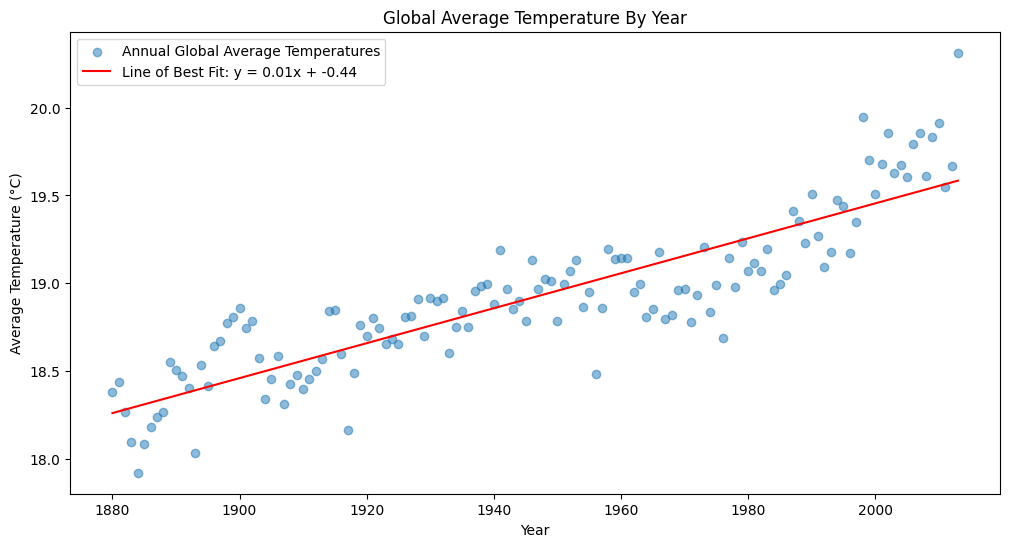

In [20]:
# Better approach: focus on more reliable/relevant data. Aggregate by year, use mean to reduce influence of regional temperature variability

df_no_missing_updated = df_no_missing_updated[df_no_missing_updated['Year'] >= 1850]

df_global_average = df_no_missing_updated.groupby('Year')['AverageTemperature'].mean().reset_index()
years = df_global_average['Year'].astype(float)
mean_temperatures = df_global_average['AverageTemperature'].astype(float)
m, b = np.polyfit(years, mean_temperatures, 1)
plt.figure(figsize=(12, 6))
plt.scatter(years, mean_temperatures, alpha=0.5, label='Annual Global Average Temperatures')
plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')

global_correlation = years.corr(mean_temperatures)
print(f"Global Correlation between Year and Average Temperature: {global_correlation}")

plt.title('Global Average Temperature By Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

Global correlation between year and Average Temperature is pretty high, about 0.85, meaning the variable Year explains about 85% of the variance in Average Temperature.

In [21]:
continent_counts = df_no_missing_updated['Continent'].value_counts()
print('Counts for each continent:\n', continent_counts)

kcc_counts = df_no_missing_updated['kcc'].value_counts()
print('\nCounts for each climate classification:\n', kcc_counts)

Counts for each continent:
 Continent
Asia             7236
Africa           2539
South America    1327
Europe           1072
North America     938
Oceania           268
Name: count, dtype: int64

Counts for each climate classification:
 kcc
Aw       2003
BSh      1742
Cfa      1206
BWh      1200
Ocean    1199
         ... 
Dwb       268
Dfa       134
BWk       134
Csb       134
ET        134
Name: count, Length: 20, dtype: int64


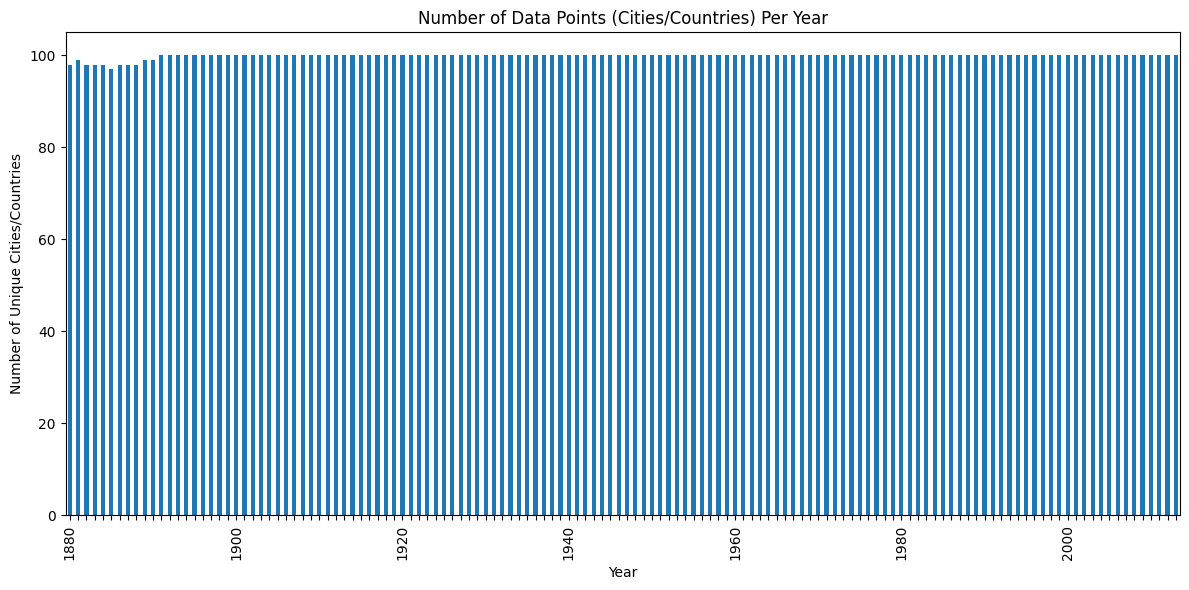

In [22]:
# Group by Year and count the number of unique cities/countries contributing to the data
data_points_by_year = df_no_missing_updated.groupby('Year')['City'].nunique()

# Plot the number of data points per year to visually assess the balance
plt.figure(figsize=(12, 6))
data_points_by_year.plot(kind='bar')
plt.title('Number of Data Points (Cities/Countries) Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique Cities/Countries')
tick_labels = [label if int(label) % 20 == 0 else '' for label in data_points_by_year.index.astype(str)]
plt.xticks(range(len(data_points_by_year.index)), tick_labels, rotation='vertical')
plt.tight_layout()
plt.show()

# Get counts of how many years each city/country has data for
city_counts = df_no_missing_updated.groupby('City')['Year'].nunique()

# Filter cities/countries to those present in all years
consistent_cities = city_counts[city_counts >= 80].index.tolist()
df_consistent_cities = df_no_missing_updated[df_no_missing_updated['City'].isin(consistent_cities)]

# Recalculate the averages using the consistent set of cities/countries
df_continent_year_avg_temp_consistent = df_consistent_cities.groupby(['Continent', 'Year'])['AverageTemperature'].mean().reset_index()
df_kcc_year_avg_temp_consistent = df_consistent_cities.groupby(['kcc', 'Year'])['AverageTemperature'].mean().reset_index()


In [23]:
# Determine the start year for analysis based on data balance
start_year = 1880
print(f'start_year is {start_year}')

# Filter the consistent datasets to only include data from the start year onwards
df_continent_year_avg_temp_consistent = df_continent_year_avg_temp_consistent[df_continent_year_avg_temp_consistent['Year'] >= start_year]
df_kcc_year_avg_temp_consistent = df_kcc_year_avg_temp_consistent[df_kcc_year_avg_temp_consistent['Year'] >= start_year]

start_year is 1880


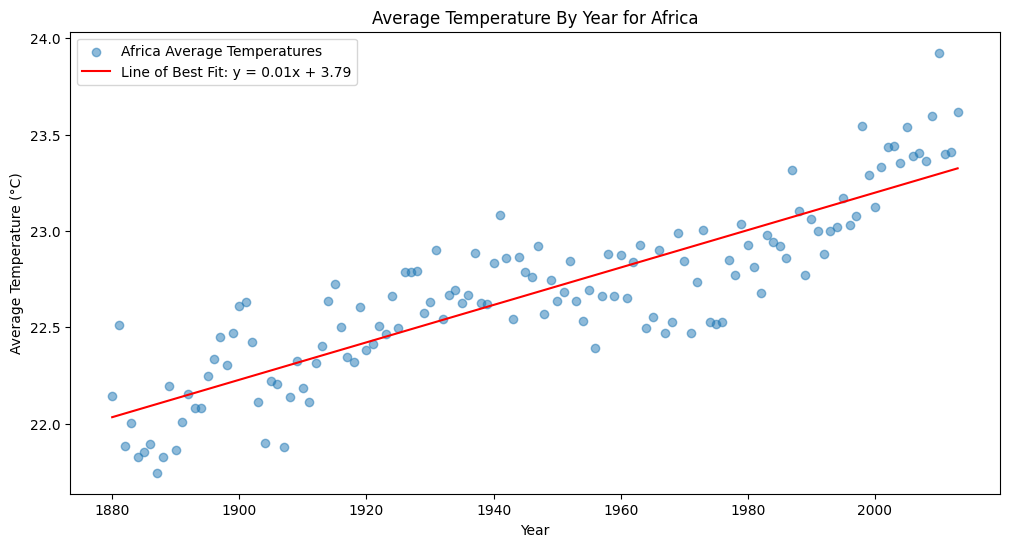

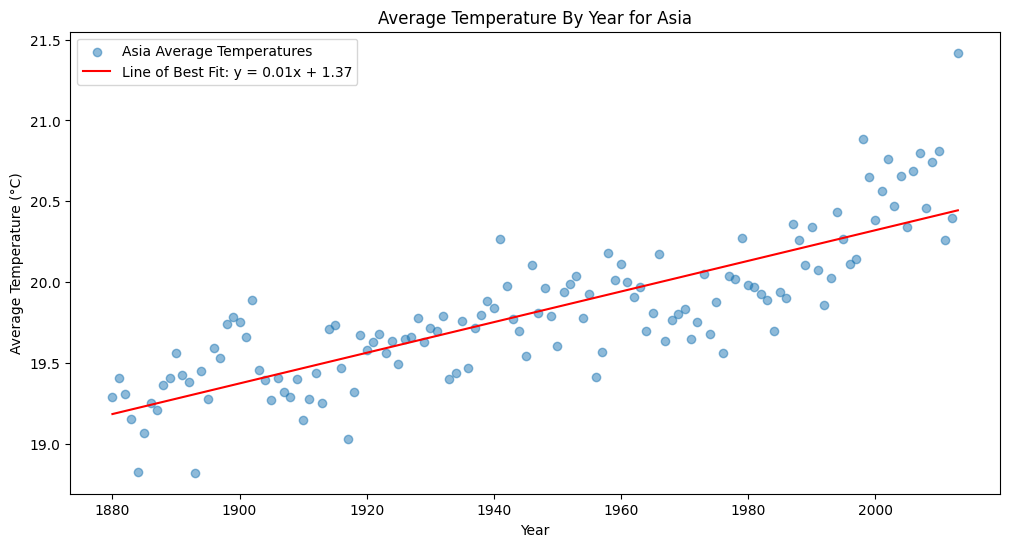

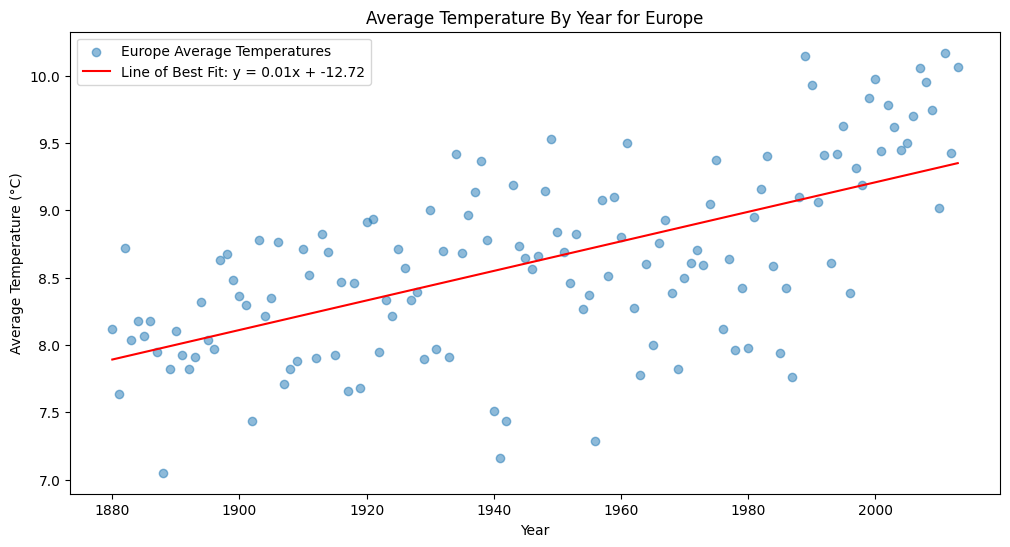

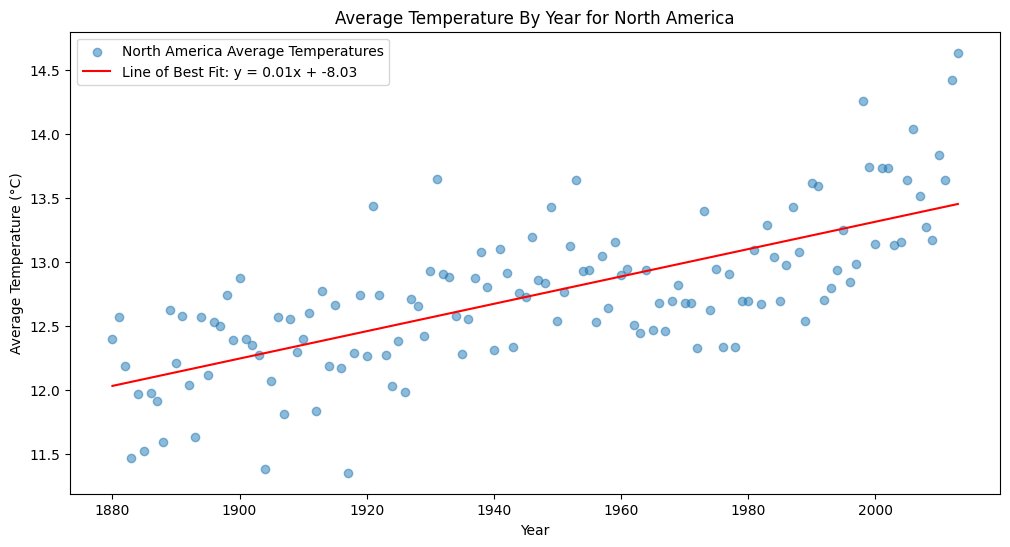

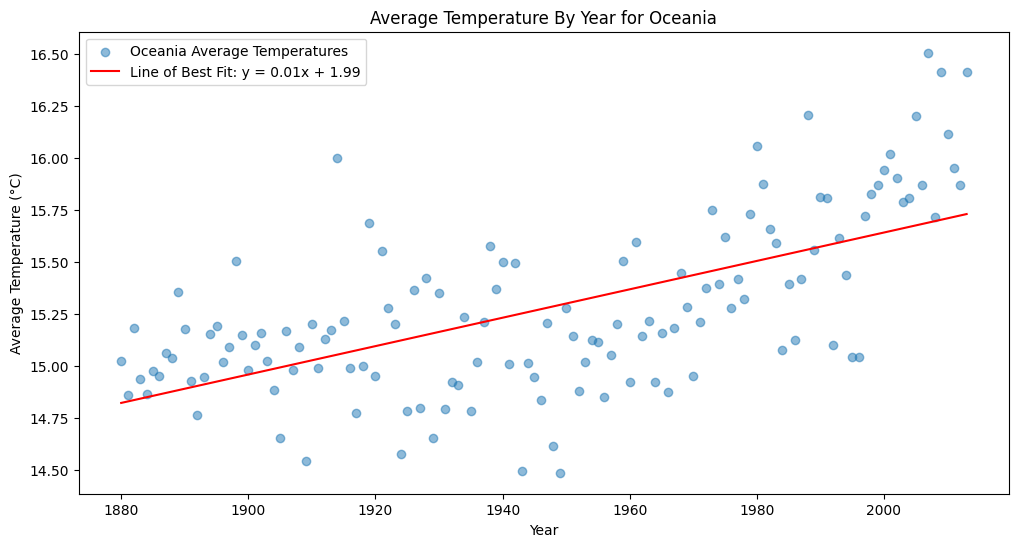

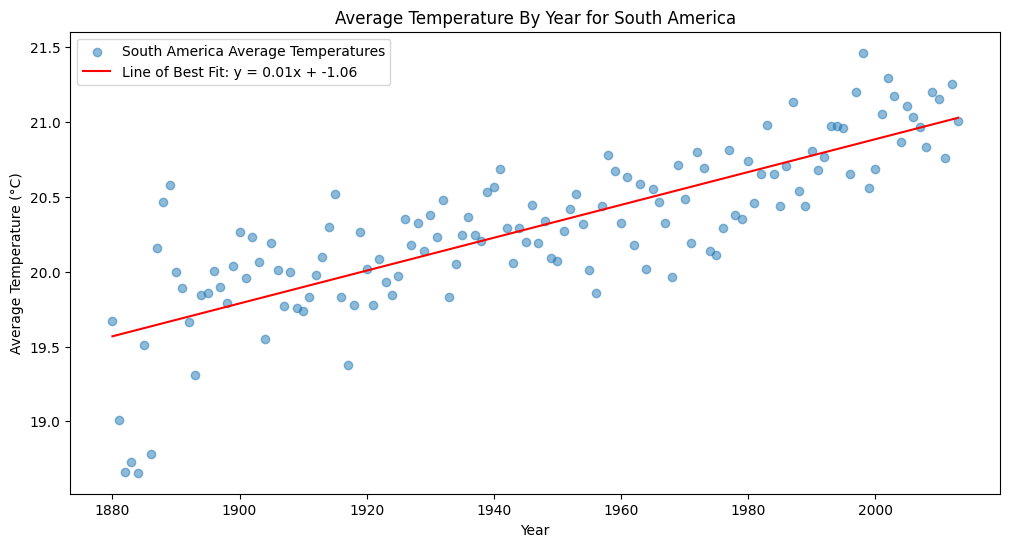

Correlation between Year and Average Temperature for Africa: 0.8675918266931837
Correlation between Year and Average Temperature for Asia: 0.831504850574978
Correlation between Year and Average Temperature for Europe: 0.6218535088722658
Correlation between Year and Average Temperature for North America: 0.7095447693894782
Correlation between Year and Average Temperature for Oceania: 0.6290581037971067
Correlation between Year and Average Temperature for South America: 0.8061429450441352


In [24]:
continent_correlations = {}

# Calculate correlation and plot for each continent
for continent in df_continent_year_avg_temp_consistent['Continent'].unique():
    # Filter the DataFrame for the current continent
    df_continent = df_continent_year_avg_temp_consistent[df_continent_year_avg_temp_consistent['Continent'] == continent]
    
    # Perform the correlation calculation
    continent_correlation = df_continent['Year'].astype(float).corr(df_continent['AverageTemperature'].astype(float))
    #print(f'Correlation between Year and Average Temperature for {continent}: {continent_correlation}')
    continent_correlations[continent] = continent_correlation
    
    # Get the years and average temperatures for plotting
    years = df_continent['Year'].astype(float)
    avg_temps = df_continent['AverageTemperature'].astype(float)
    
    # Calculate the line of best fit
    m, b = np.polyfit(years, avg_temps, 1)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(years, avg_temps, alpha=0.5, label=f'{continent} Average Temperatures')
    plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')
    plt.title(f'Average Temperature By Year for {continent}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.show()

for continent, correlation in continent_correlations.items():
    print(f'Correlation between Year and Average Temperature for {continent}: {correlation}')

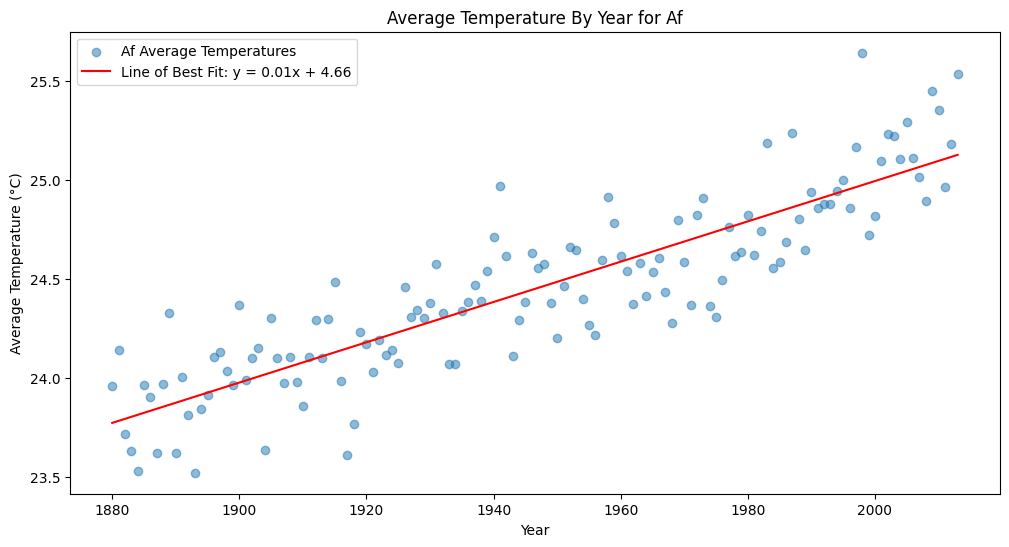

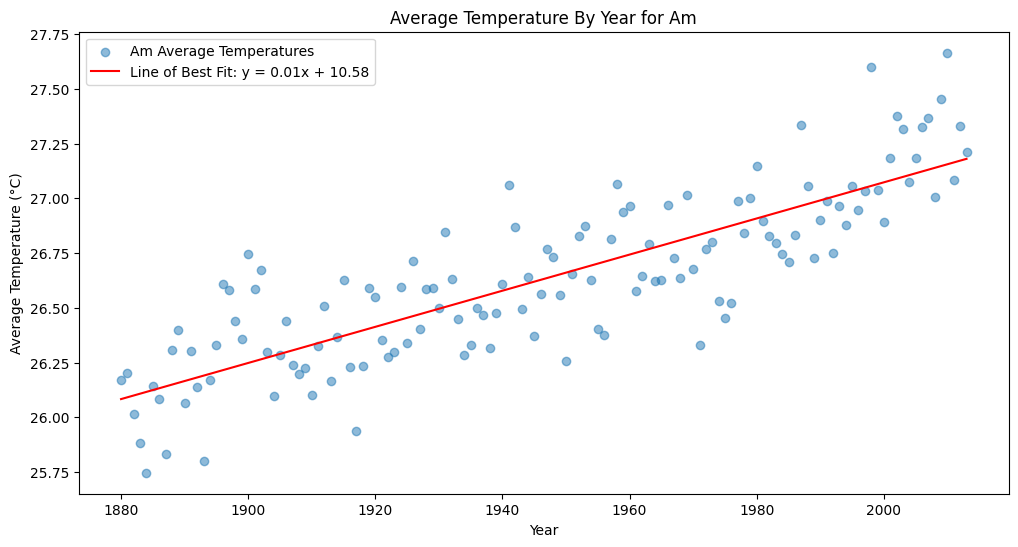

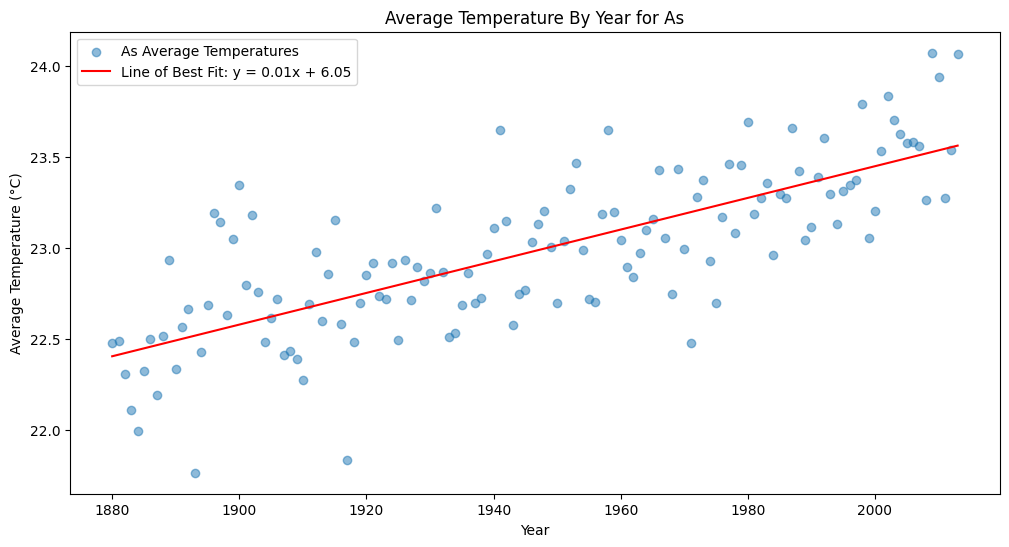

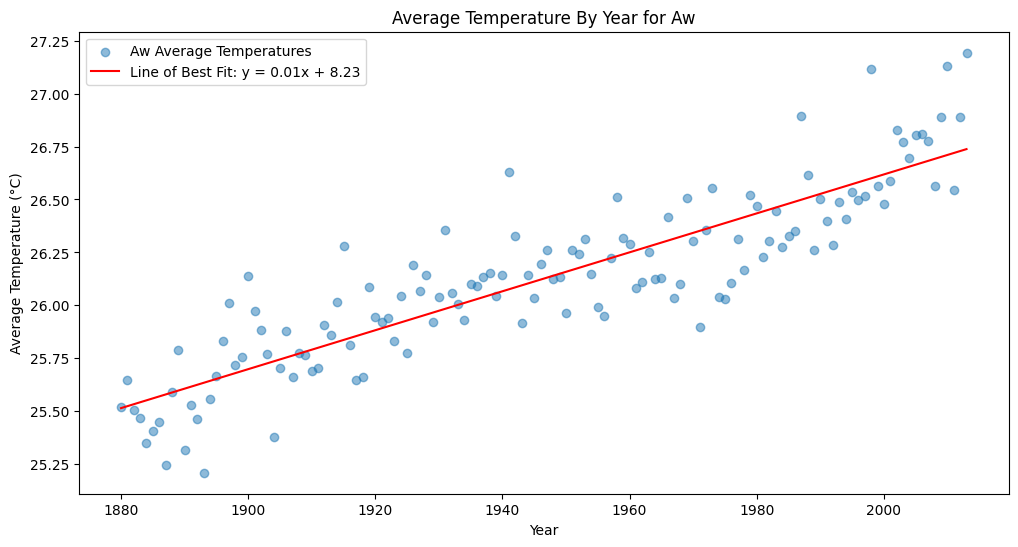

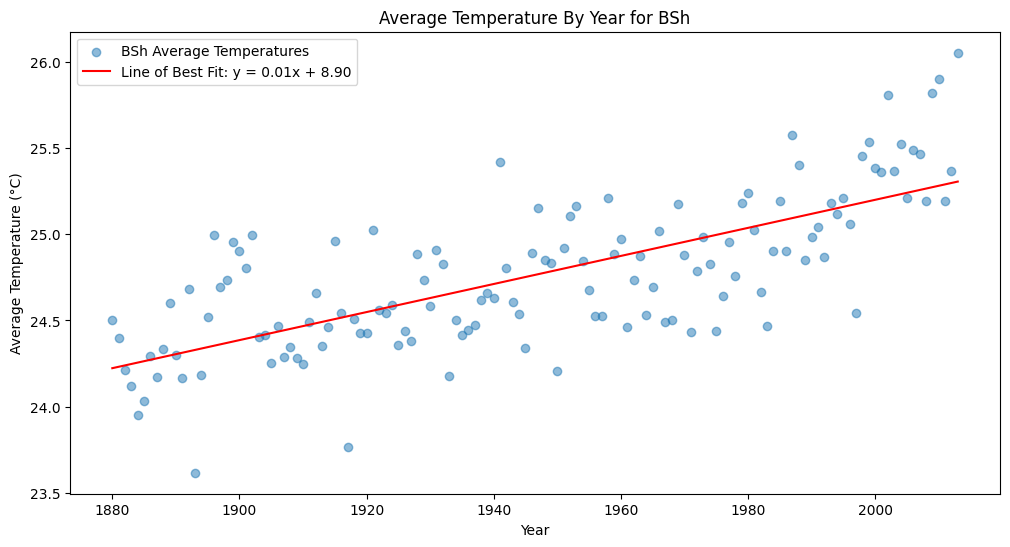

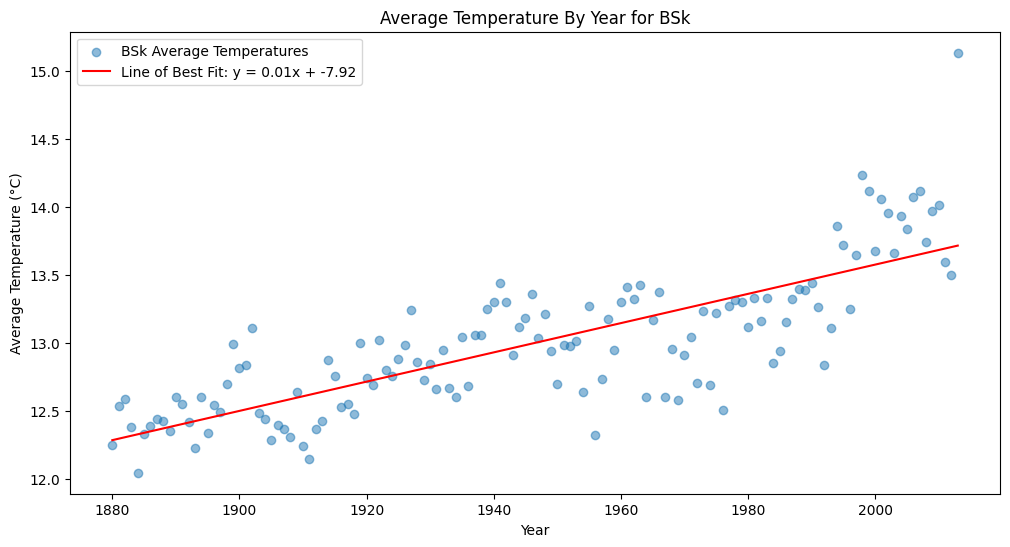

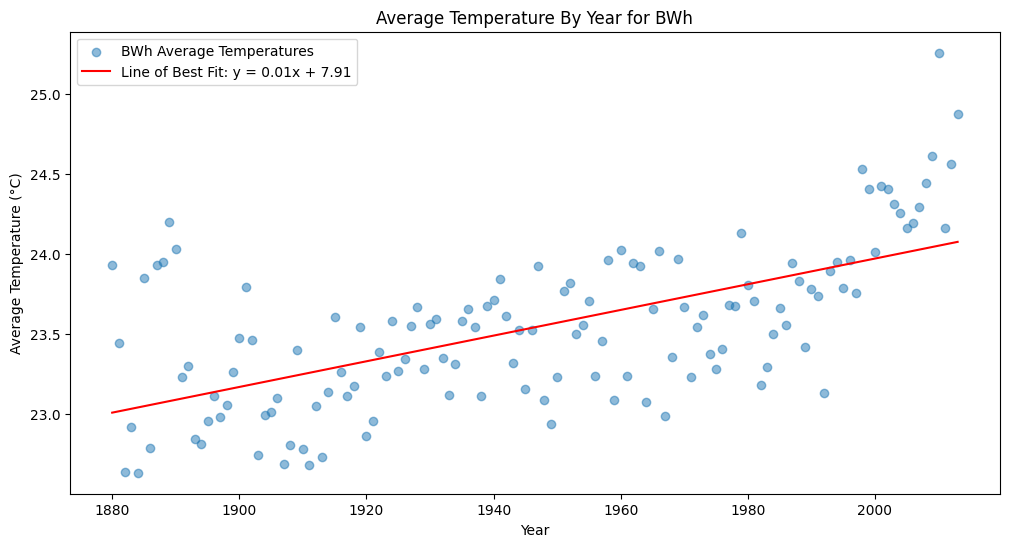

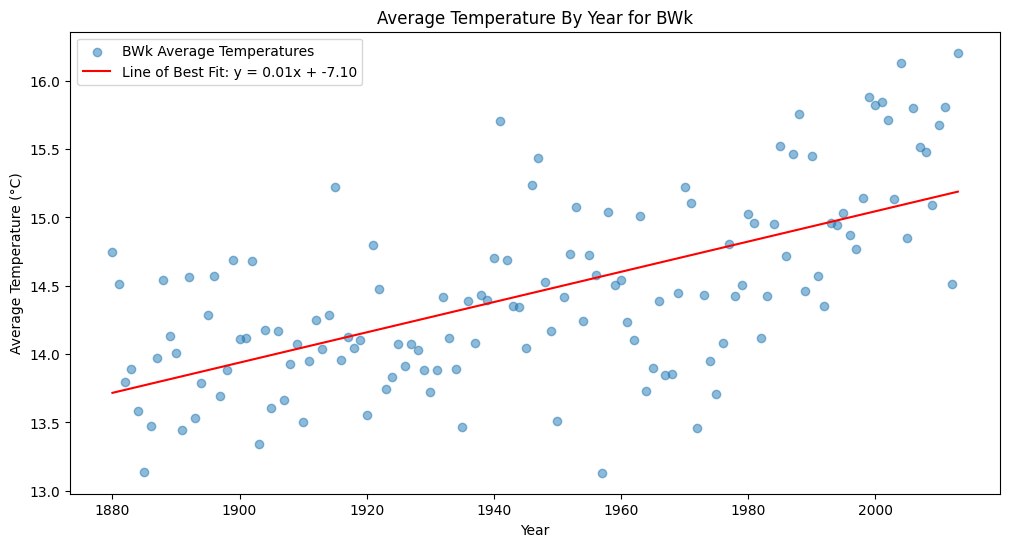

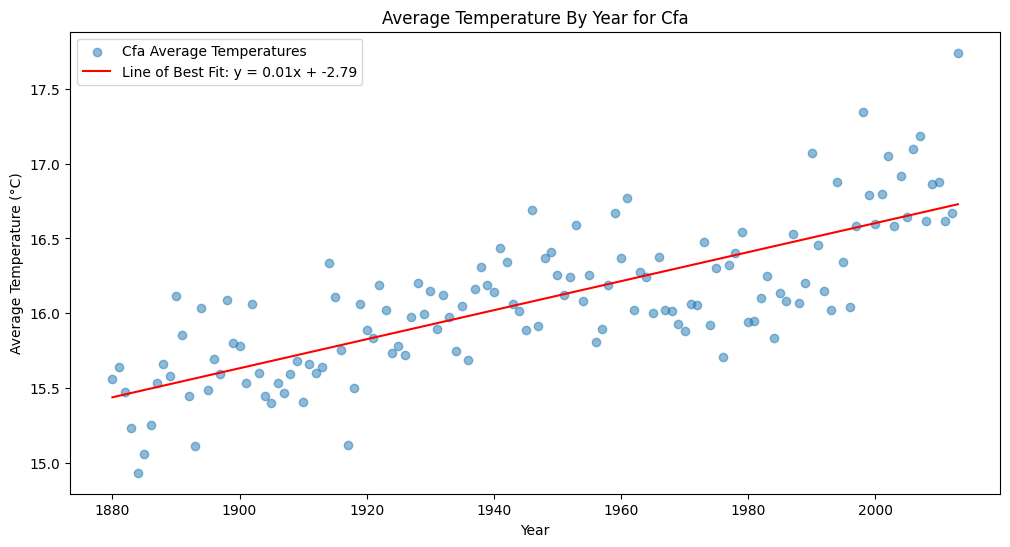

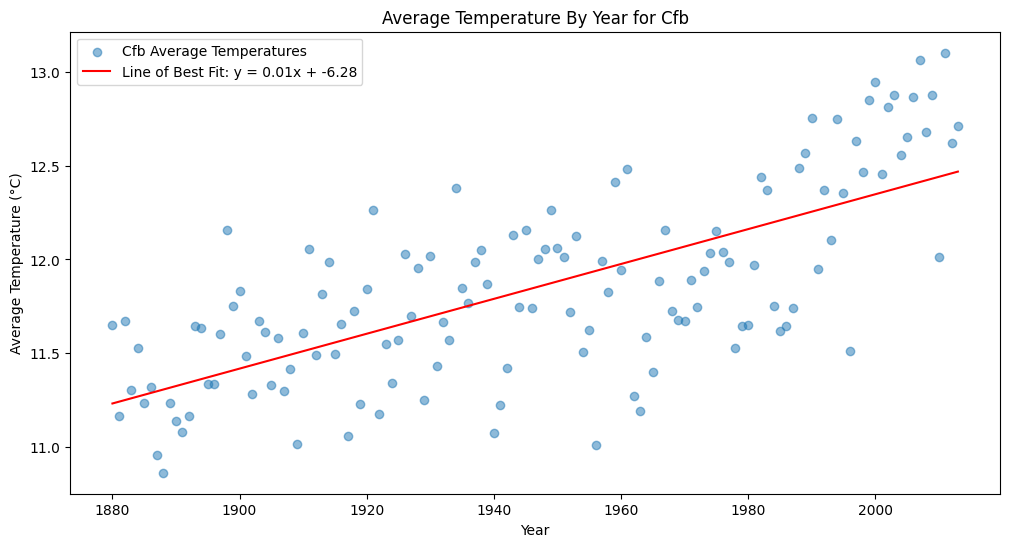

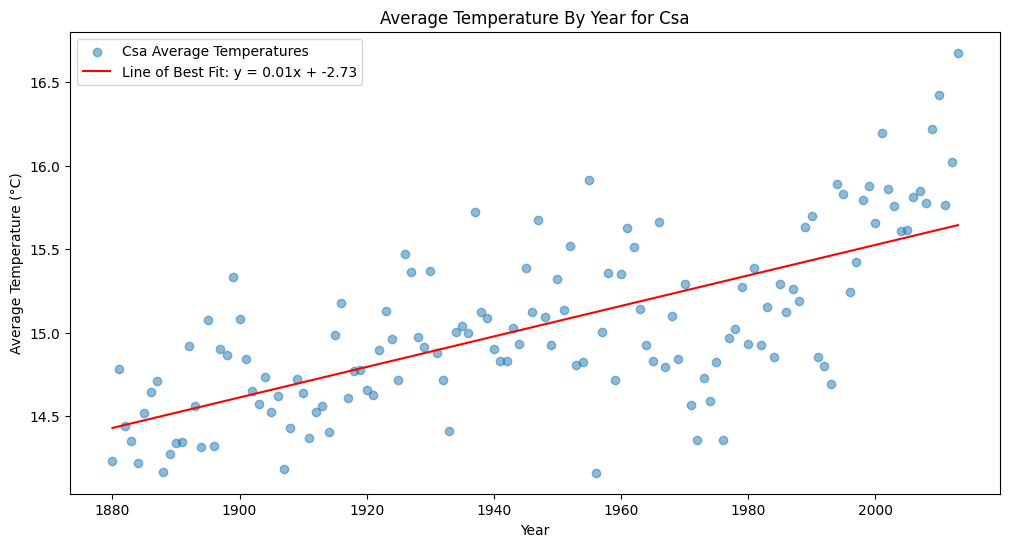

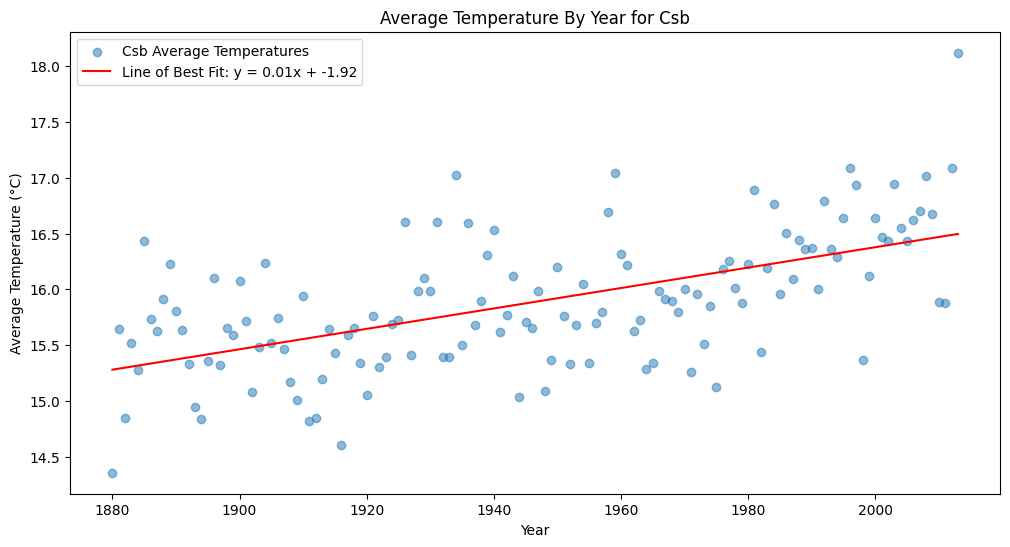

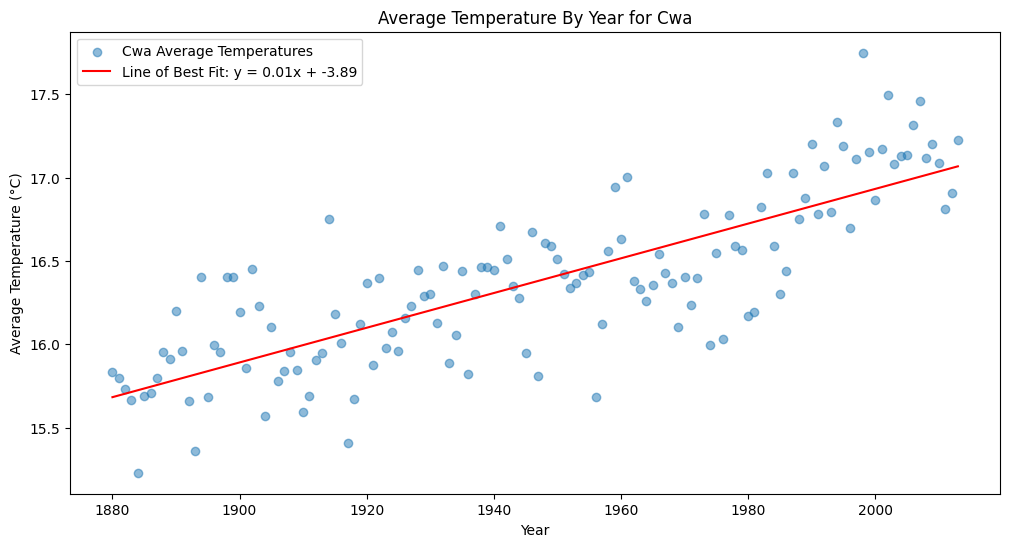

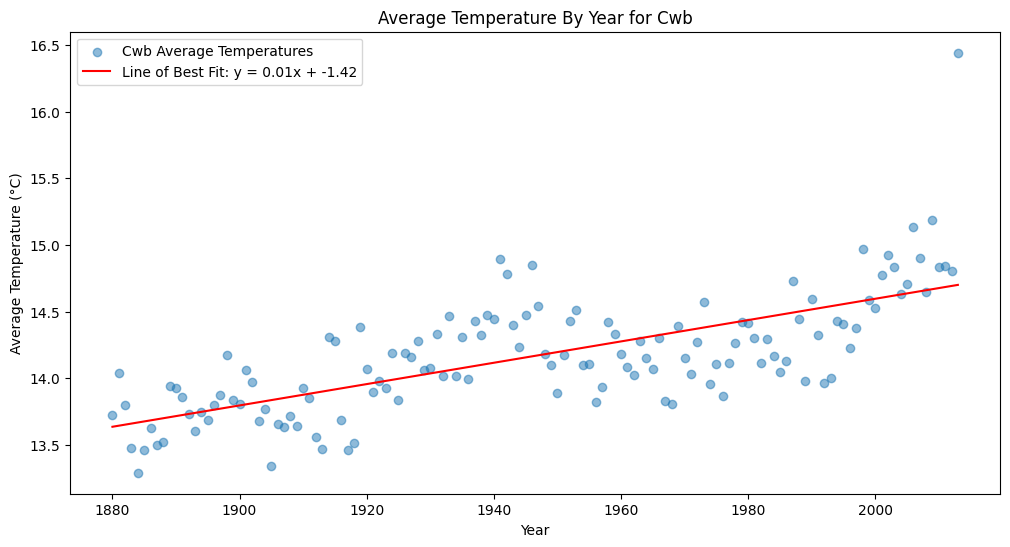

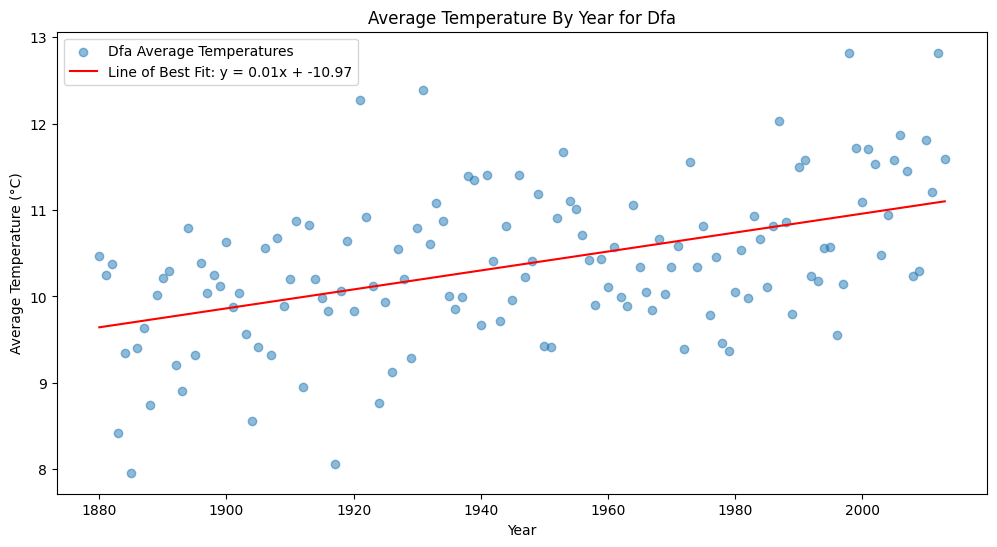

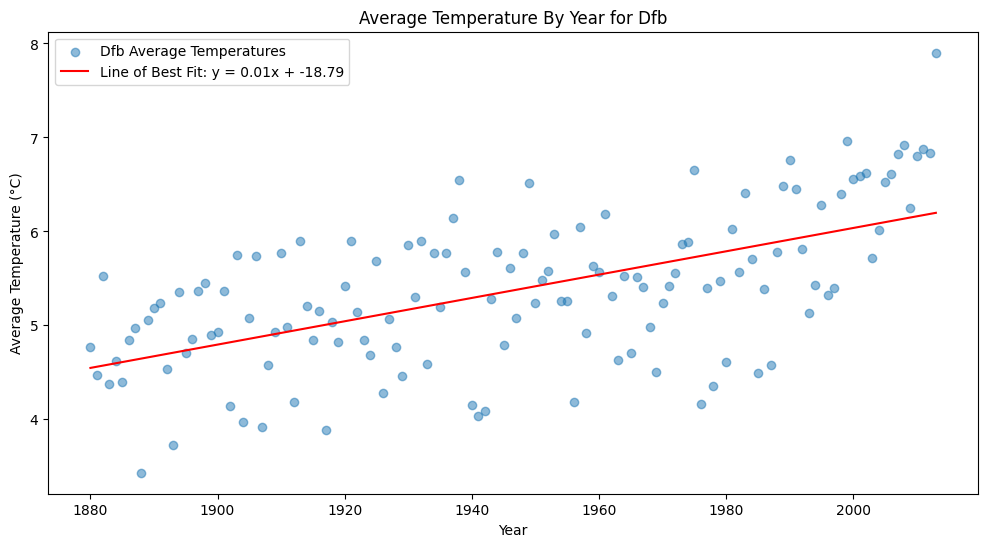

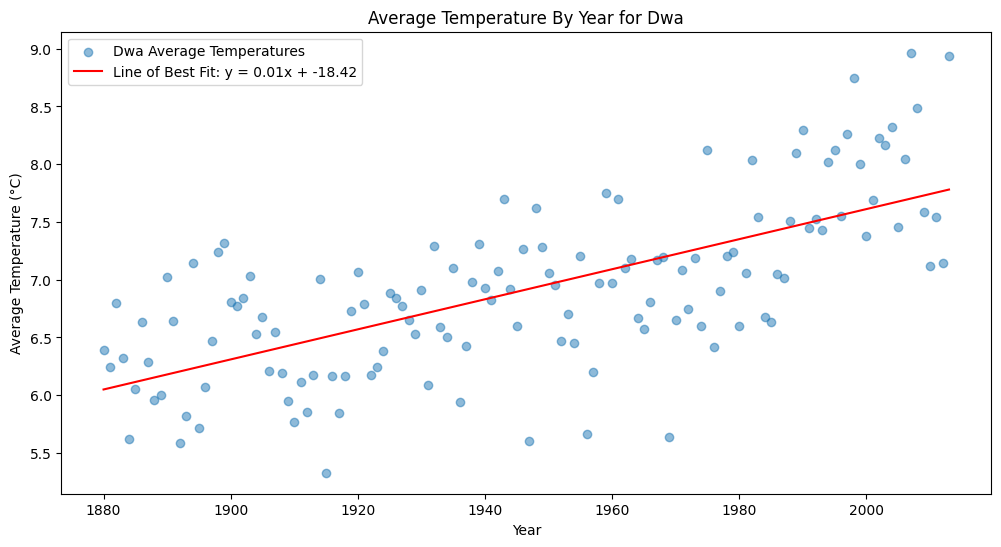

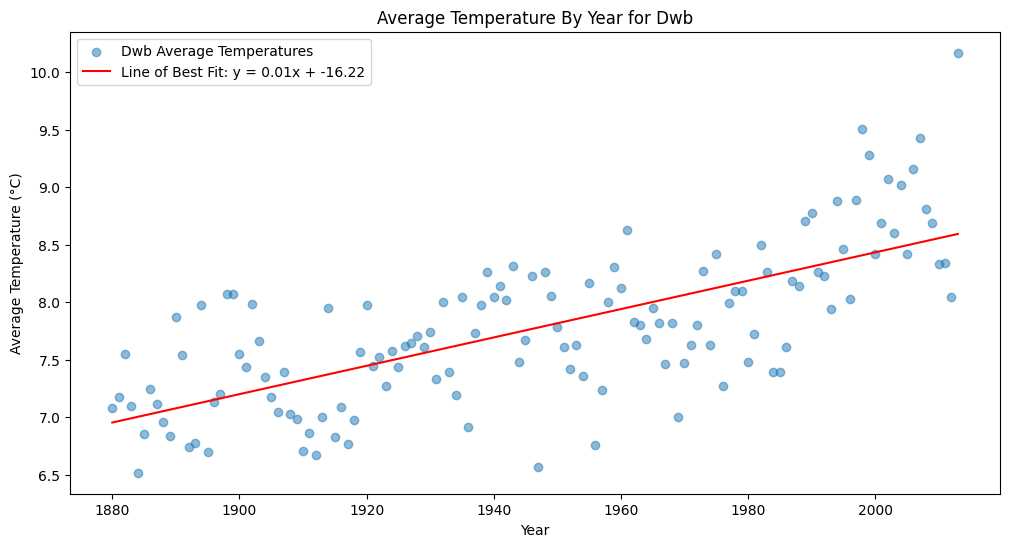

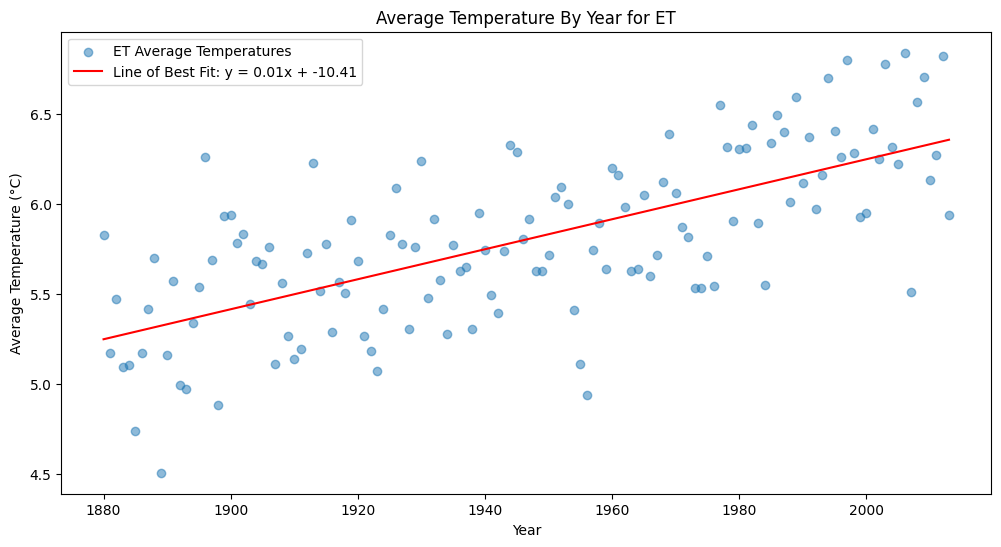

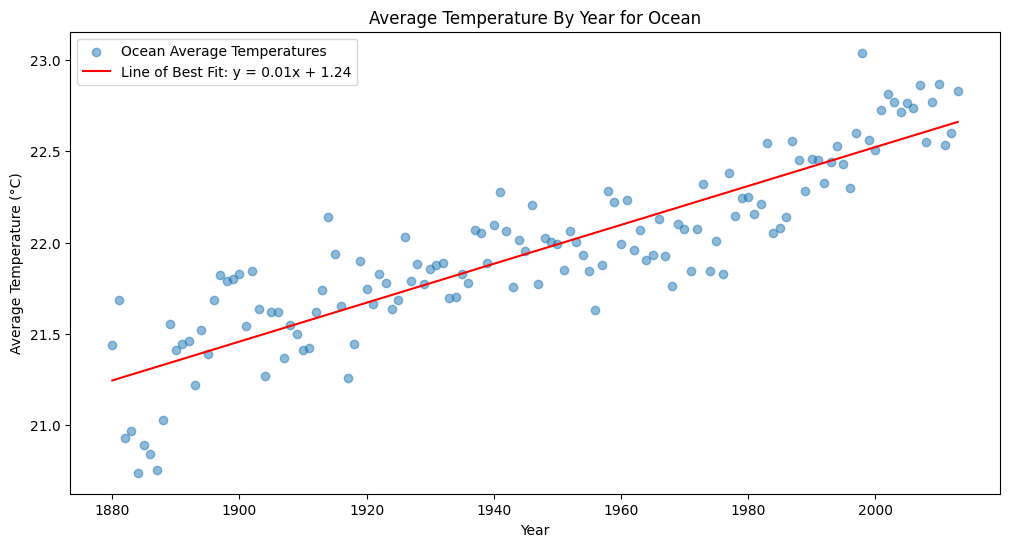

Correlation between Year and Average Temperature for Af: 0.8770531820618657
Correlation between Year and Average Temperature for Am: 0.8342212664156524
Correlation between Year and Average Temperature for As: 0.7609701104419582
Correlation between Year and Average Temperature for Aw: 0.880195278933532
Correlation between Year and Average Temperature for BSh: 0.7250352113771369
Correlation between Year and Average Temperature for BSk: 0.7969972402713376
Correlation between Year and Average Temperature for BWh: 0.627064464979538
Correlation between Year and Average Temperature for BWk: 0.63488419196725
Correlation between Year and Average Temperature for Cfa: 0.7756312150693028
Correlation between Year and Average Temperature for Cfb: 0.7073674591340265
Correlation between Year and Average Temperature for Csa: 0.6905889686792304
Correlation between Year and Average Temperature for Csb: 0.5862080004332304
Correlation between Year and Average Temperature for Cwa: 0.8039581499174893
Correla

In [25]:
kcc_correlations = {}

# Calculate correlation and plot for each continent
for climate in df_kcc_year_avg_temp_consistent['kcc'].unique():
    # Filter the DataFrame for the current continent
    df_kcc = df_kcc_year_avg_temp_consistent[df_kcc_year_avg_temp_consistent['kcc'] == climate]
    
    # Perform the correlation calculation
    kcc_correlation = df_kcc['Year'].astype(float).corr(df_kcc['AverageTemperature'].astype(float))
    #print(f"Correlation between Year and Average Temperature for {climate}: {kcc_correlation}")
    kcc_correlations[climate] = kcc_correlation
    
    # Get the years and average temperatures for plotting
    years = df_kcc['Year'].astype(float)
    avg_temps = df_kcc['AverageTemperature'].astype(float)
    
    # Calculate the line of best fit
    m, b = np.polyfit(years, avg_temps, 1)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(years, avg_temps, alpha=0.5, label=f'{climate} Average Temperatures')
    plt.plot(years, m*years + b, color='red', label=f'Line of Best Fit: y = {m:.2f}x + {b:.2f}')
    plt.title(f'Average Temperature By Year for {climate}')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.show()
    

for climate, correlation in kcc_correlations.items():
    print(f'Correlation between Year and Average Temperature for {climate}: {correlation}')

In [26]:
continent_correlations = df_no_missing_updated.groupby('Continent').apply(
    lambda group: group['Year'].astype(float).corr(group['AverageTemperature'].astype(float)),
    include_groups=False
)
print('Correlation values for each continent:\n', continent_correlations)

kcc_correlations = df_no_missing_updated.groupby('kcc').apply(
    lambda group: group['Year'].astype(float).corr(group['AverageTemperature'].astype(float)),
    include_groups=False
)
print('\nCorrelation values for each unique climate classification:\n', kcc_correlations)

Correlation values for each continent:
 Continent
Africa           0.094455
Asia             0.050944
Europe           0.141568
North America    0.060973
Oceania          0.141034
South America    0.075132
dtype: float64

Correlation values for each unique climate classification:
 kcc
Af       0.194367
Am       0.572583
As       0.114866
Aw       0.220139
BSh      0.133236
           ...   
Dfb      0.313484
Dwa      0.141793
Dwb      0.595003
ET       0.685554
Ocean    0.079720
Length: 20, dtype: float64


Climate types where the correlation between Year and Average Temperature is larger than the global correlation suggests that these regions are warming more rapidly than the planet as a whole, based on this dataset. Which regions are these, and what cities are in them?

It should be noted that Climate classifications aren't the end-all, be-all, i.e. there is variability within one climate type and geographic factors as well as human factors can influence temperature, including ocean currents, the urban heat island effect, deforestation, and pollution.

### Further Pattern Examination

Continued in Analysis 2.ipynb

In [27]:
# Put current results into a CSV for later
df_no_missing_updated.to_csv('Data_augmented.csv', index=False)